# Leaf Disease Classification en Kaggle

## Competencia
- **Nombre:** Cassava Leaf Disease Classification  
- **Enlace:** https://www.kaggle.com/competitions/cassava-leaf-disease-classification/overview  
- **Objetivo:** Clasificar imágenes de hojas de yuca en cinco categorías (enfermedad o sana), contribuyendo al control de plagas y al incremento de la productividad agrícola.

## Notebook de entrenamiento
- **Autor:** Ricardo Lopera  
- **Enlace:** https://www.kaggle.com/code/ricardolopera/leaf-disease-classification  

> **Nota importante:**  
> Al final del desarrollo en Kaggle Notebook se produjo un error al guardar el borrador. No obstante, el repositorio que acompaña este notebook contiene la versión completa del entrenamiento.

## Modelo obtenido

- **Enlace:** https://drive.google.com/file/d/1h9Jz0Qex0zRKHVqLO5vvnSm1GAOsEfeB/view?usp=sharing 

## Recursos de cómputo: TPU en Kaggle
- Kaggle ofrece **un núcleo de TPU v3** (Tensor Processing Unit) por notebook de forma gratuita.  
- Una TPU es un acelerador especializado diseñado por Google para optimizar operaciones de TensorFlow y acelerar el entrenamiento de redes neuronales profundas.  
- Aunque la TPU de Kaggle consta de un pod de 8 núcleos, en este proyecto se utilizó únicamente **un solo núcleo**, por lo que el tiempo de entrenamiento fue de **casi 3 horas**.

---

### Cómo funcionan las TPU en Kaggle
1. **Selección del acelerador:**  
   En la configuración del notebook, se elige “TPU” en lugar de CPU o GPU.  
2. **Distribución automática:**  
   TensorFlow detecta el entorno TPU y ejecuta las operaciones de forma distribuida sobre los núcleos disponibles.  
3. **Ventajas principales:**  
   - Mejora significativa en velocidad de entrenamiento y evaluación.  
   - Mayor eficiencia energética frente a GPU/CPU convencionales.  
4. **Consideraciones:**  
   - Hay que usar estrategias de distribución (`tf.distribute.TPUStrategy`).  
   - El límite de memoria y de tiempo de sesión de Kaggle Notebook aplica también a TPU.


# Clasificación de Enfermedades en Hojas de Yuca usando Vision Transformers

## Descripción del Proyecto
Este notebook implementa un modelo de clasificación de enfermedades en hojas de yuca utilizando Vision Transformers (ViT), participando en la competencia "Cassava Leaf Disease Classification" de Kaggle.

## Componentes Principales

### 1. Preparación de Datos
- Carga del dataset desde Kaggle
- Implementación de data augmentation con transformaciones como:
  - Volteos horizontales y verticales
  - Rotaciones aleatorias
  - Transformaciones afines
  - Normalización de imágenes

### 2. Arquitectura del Modelo
- Implementación de ViTBase16 (Vision Transformer)
- Adaptación de la capa final para 5 clases (enfermedades)

### 3. Entrenamiento
- Utilización de TPU para aceleración del entrenamiento
- Implementación de entrenamiento distribuido
- Hiperparámetros clave:
  - Tamaño de imagen: 224x224
  - Batch size: 16
  - Learning rate: 2e-05
  - Épocas: 10

### 4. Optimizaciones
- Manejo eficiente de memoria con garbage collection
- Implementación de early stopping
- Guardado del mejor modelo basado en pérdida de validación

### 5. Monitoreo
- Seguimiento de métricas:
  - Pérdida de entrenamiento y validación
  - Precisión de entrenamiento y validación
- Visualización de la distribución de clases

## Resultados
El modelo se entrenó durante aproximadamente 3 horas en TPU, implementando técnicas de data augmentation y optimización para mejorar la robustez y precisión en la clasificación de enfermedades en hojas de yuca.

In [1]:
#Importamos las librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import timm
import gc
import os
import time
import random
from datetime import datetime
from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics
import os
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
import seaborn as sns

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Tomamos los datos de Kaggle y los cargamos en un DataFrame

Data = "/kaggle/input/cassava-leaf-disease-classification"
Train = "/kaggle/input/cassava-leaf-disease-classification/train_images/"
Test = "/kaggle/input/cassava-leaf-disease-classification/test_images/"


df = pd.read_csv(os.path.join(Data, "train.csv"))

Para este proyecto se hará uso del TPU proporcionado por Kaggle, para lo cual implementaremos primero paralelización del TPU. Esto nos permitirá acelerar el entrenamiento de modelos de deep learning utilizando la librería Torch XLA, que facilita la integración de PyTorch con dispositivos TPU. La paralelización se logra distribuyendo los datos y el proceso de entrenamiento entre los diferentes núcleos del TPU, optimizando así el uso de recursos y reduciendo significativamente el tiempo de entrenamiento. Además, se emplearán técnicas como el uso de DataLoader y ParallelLoader para manejar eficientemente los datos durante el entrenamiento distribuido.

`XLA_USE_BF16`: Activa el uso de precisión mixta (BF16), lo que acelera el entrenamiento y reduce el consumo de memoria en TPU.
`XLA_TENSOR_ALLOCATOR_MAXSIZE`: Limita el tamaño máximo del asignador de tensores en XLA, ayudando a controlar el uso de memoria.

In [3]:
os.environ["XLA_USE_BF16"] = "1"
os.environ["XLA_TENSOR_ALLOCATOR_MAXSIZE"] = "100000000"

# Para la reproducibilidad de los resultados hacemos uso de una semilla fija
# Esto asegura que los resultados sean consistentes en diferentes ejecuciones

def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(42)

### Definición de Parámetros: `IMG_SIZE`, `BATCH_SIZE`, `LR`, y `N_EPOCHS`

En este apartado, vamos a definir los parámetros clave para configurar el entrenamiento de nuestro modelo Vision Transformer (ViT) para la clasificación de enfermedades en hojas. Estos parámetros influirán directamente en el comportamiento y rendimiento del modelo durante el entrenamiento.

1. **`IMG_SIZE = 224`**:
   El parámetro `IMG_SIZE` define el tamaño de las imágenes de entrada que se alimentan al modelo. Dado que estamos utilizando un **Vision Transformer (ViT)**, que requiere imágenes de un tamaño específico, hemos decidido establecer un tamaño de imagen de **224x224 píxeles**. Este es un tamaño comúnmente utilizado en muchos modelos preentrenados, lo que ayuda a optimizar el tiempo de entrenamiento sin perder demasiada resolución en las imágenes.

   - **Razón para elegir `224x224`**: Este tamaño es un compromiso entre calidad y eficiencia computacional. Permite capturar suficiente detalle en las imágenes para tareas de clasificación, mientras mantiene un tamaño manejable para los recursos computacionales.

2. **`BATCH_SIZE = 16`**:
   El `BATCH_SIZE` determina cuántas imágenes serán procesadas en cada iteración del entrenamiento. Con un `batch_size` de **16**, el modelo procesará 16 imágenes simultáneamente en cada paso, actualizando los parámetros basados en el cálculo de los gradientes promedio. Un tamaño de lote más pequeño (como 16) ayuda a reducir el consumo de memoria y puede mejorar la generalización, pero también puede hacer que el entrenamiento sea más ruidoso debido a la mayor variabilidad en los gradientes.

   - **Consideraciones para elegir `16`**: Un tamaño de 16 es una opción común que ofrece un buen equilibrio entre eficiencia computacional y generalización en modelos de visión por computadora. En algunos casos, podría ser necesario ajustar este valor dependiendo del tamaño de las imágenes o la memoria disponible.

3. **`LR = 2e-05`** (Learning Rate):
   La **tasa de aprendizaje** (`LR`) controla qué tan grande es el paso que da el modelo en cada actualización de los parámetros durante el entrenamiento. Un valor de **2e-05** indica que el modelo hará pequeñas actualizaciones en cada iteración. Esto puede ser útil para evitar que el modelo dé pasos demasiado grandes, lo que podría llevar a una mala convergencia o incluso hacer que el entrenamiento se vuelva inestable.

   - **Razón para elegir `2e-05`**: Este valor es un buen punto de partida basado en modelos preentrenados de ViT. Sin embargo, la tasa de aprendizaje podría ajustarse según el comportamiento observado en el entrenamiento. Si el modelo se entrena demasiado lento, se podría intentar aumentar la tasa de aprendizaje; si el modelo se vuelve inestable, se debería reducir.

4. **`N_EPOCHS = 10`**:
   El número de **`epochs`** define cuántas veces todo el conjunto de datos se pasará a través del modelo. Un valor de **10** implica que el modelo entrenará durante 10 pasadas completas sobre el conjunto de entrenamiento. El número de epochs es crucial porque un valor bajo podría resultar en un entrenamiento insuficiente, mientras que uno alto podría dar lugar a sobreajuste (overfitting).

   - **Consideraciones para elegir `10`**: En este caso, 10 épocas es un valor inicial razonable para observar cómo el modelo se ajusta a los datos. Dependiendo de los resultados, podríamos aumentar o disminuir este valor. Es importante observar el rendimiento en el conjunto de validación para determinar si el modelo está aprendiendo adecuadamente o si es necesario más entrenamiento.




In [4]:
IMG_SIZE = 224

BATCH_SIZE = 16

LR = 2e-05

N_EPOCHS = 10

In [5]:
# Veamos como son los datos 
df = pd.read_csv(os.path.join(Data, "train.csv"))

# Realizamos la separacion de train y test:
train_df, valid_df = model_selection.train_test_split(df, 
                                                      test_size=0.1, 
                                                      random_state=42, 
                                                      stratify=df.label.values)

df.head()



,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


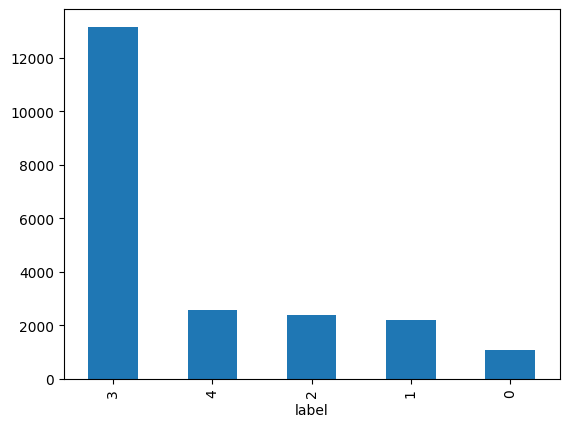

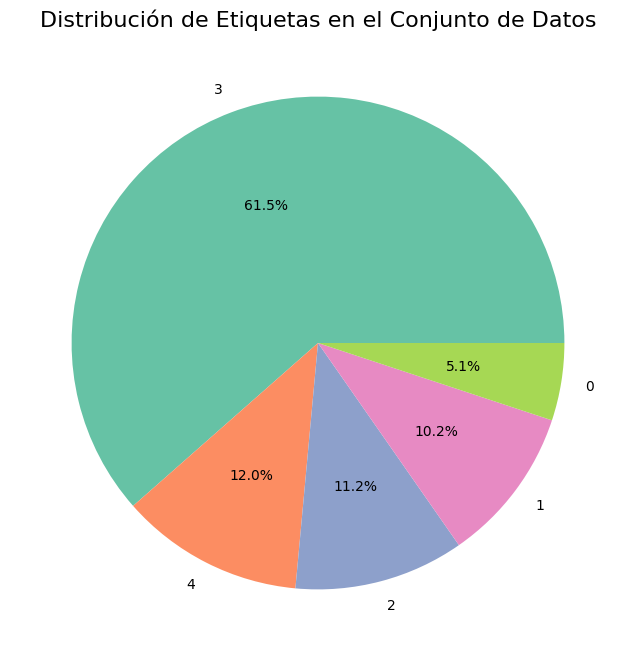

In [6]:
# Graficamos el diagrama de barras
df.label.value_counts().plot(kind="bar")

label_counts = df.label.value_counts()

# Graficamos el pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', colors=sns.color_palette("Set2", len(label_counts)))

plt.title('Distribución de Etiquetas en el Conjunto de Datos', fontsize=16)

plt.show()


### Conjunto de Datos Cassava

El código a continuación define una clase llamada `CassavaDataset`, que facilita la creación de un conjunto de datos personalizado en PyTorch. Esta clase está diseñada específicamente para cargar y preprocesar imágenes del conjunto de datos **Cassava**, que se utilizan para entrenar o evaluar modelos de clasificación de enfermedades en plantas de cassava.

1. **Inicialización (`__init__`)**:
   - El constructor de la clase recibe varios parámetros: 
     - `df`: un DataFrame que contiene los nombres de las imágenes y sus etiquetas.
     - `data_path`: la ruta donde se almacenan las imágenes. Por defecto, se utiliza `Data`.
     - `mode`: un valor que indica si el conjunto de datos es de entrenamiento ("train") o prueba ("test").
     - `transforms`: un parámetro opcional que permite aplicar transformaciones de preprocesamiento (como normalización o aumentos de datos) a las imágenes antes de ser procesadas por el modelo.
   - Dependiendo del valor de `mode`, se selecciona el directorio adecuado (`train_images` o `test_images`) donde se encuentran las imágenes.

2. **Tamaño del Conjunto de Datos (`__len__`)**:
   - El método `__len__` devuelve el número total de imágenes en el conjunto de datos, que se obtiene del DataFrame `df`. Esto es útil para saber cuántas muestras hay disponibles para el entrenamiento o la evaluación.

3. **Obtención de un Ítem del Conjunto de Datos (`__getitem__`)**:
   - El método `__getitem__` toma un índice y retorna una imagen y su etiqueta correspondiente.
   - Primero, se construye la ruta completa de la imagen basándose en el índice y el directorio de imágenes.
   - Luego, se carga la imagen desde el disco y se convierte a formato RGB.
   - Si se han definido transformaciones (como redimensionamiento o normalización), estas se aplican a la imagen antes de devolverla.
   - Finalmente, el método retorna tanto la imagen procesada como su etiqueta.

En resumen, esta clase permite cargar y transformar eficientemente las imágenes del conjunto de datos Cassava, facilitando su uso en el entrenamiento y evaluación de modelos de aprendizaje automático en PyTorch.


In [7]:
class CassavaDataset(torch.utils.data.Dataset):

    def __init__(self, df, data_path= Data, mode="train", transforms=None):
        super().__init__()
        self.df_data = df.values
        self.data_path = data_path
        self.transforms = transforms
        self.mode = mode
        self.data_dir = "train_images" if mode == "train" else "test_images"

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        img_path = os.path.join(self.data_path, self.data_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        if self.transforms is not None:
            image = self.transforms(img)

        return image, label

### Data Augmentation

El código a continuación define dos conjuntos de transformaciones para los datos de entrenamiento y validación. Estas transformaciones son aplicadas a las imágenes antes de ser alimentadas al modelo, con el fin de mejorar su generalización y ayudar a prevenir el sobreajuste (overfitting) al introducir variaciones en los datos.

1. **Transformaciones para el Conjunto de Entrenamiento (`transforms_train`)**:
   - **`Resize`**: Redimensiona las imágenes a un tamaño específico, definido por `IMG_SIZE` (que es un valor previamente definido, como 224x224 píxeles). Esto asegura que todas las imágenes tengan un tamaño uniforme antes de ser procesadas.
   - **`RandomHorizontalFlip`**: Realiza un volteo horizontal de las imágenes con una probabilidad del 30%. Esto ayuda a que el modelo sea menos sensible a la orientación de las imágenes.
   - **`RandomVerticalFlip`**: Realiza un volteo vertical de las imágenes con una probabilidad del 30%. De nuevo, esto aumenta la variabilidad de las imágenes y mejora la robustez del modelo.
   - **`RandomRotation`**: Rota las imágenes aleatoriamente en un rango de hasta 10 grados. Esta transformación es útil para simular variaciones en la orientación de las hojas.
   - **`RandomAffine`**: Aplica una transformación afín aleatoria en las imágenes, con un rango de 10 grados. Esto puede incluir cambios en la escala y rotación de la imagen.
   - **`RandomResizedCrop`**: Recorta aleatoriamente una porción de la imagen y la redimensiona a `IMG_SIZE`. Esto ayuda a simular variaciones en el encuadre y la escala de los objetos.
   - **`ToTensor`**: Convierte la imagen en un tensor de PyTorch, lo que la prepara para ser utilizada en un modelo de aprendizaje automático.
   - **`Normalize`**: Normaliza las imágenes utilizando los valores de media y desviación estándar de los canales de color (Rojo, Verde y Azul). Esto es importante para que el modelo pueda aprender de manera más eficiente.

2. **Transformaciones para el Conjunto de Validación (`transforms_valid`)**:
   - **`Resize`**: Similar al conjunto de entrenamiento, redimensiona las imágenes a `IMG_SIZE`.
   - **`ToTensor`**: Convierte las imágenes en tensores de PyTorch.
   - **`Normalize`**: Normaliza las imágenes utilizando los mismos valores de media y desviación estándar que en el conjunto de entrenamiento, para asegurar que las imágenes de validación tengan la misma escala que las de entrenamiento.


In [8]:
# Tiempo para realizar aumentos de datos (Data Augmentation)

# Conjunto de transformaciones para el conjunto de entrenamiento
transforms_train = transforms.Compose(
[
    # Redimensiona la imagen al tamaño previamente especificado en IMG_SIZE
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    
    # Voltea aleatoriamente las imágenes de manera horizontal con una probabilidad del 30%
    transforms.RandomHorizontalFlip(p=0.3),
    
    # Voltea aleatoriamente las imágenes de manera vertical con una probabilidad del 30%
    transforms.RandomVerticalFlip(p=0.3),
    
    # Rota aleatoriamente las imágenes hasta 10 grados
    transforms.RandomRotation(10),
    
    # Aplica una transformación afín aleatoria de hasta 10 grados
    transforms.RandomAffine(10),
    
    # Recorta aleatoriamente las imágenes y las redimensiona al tamaño especificado por IMG_SIZE
    transforms.RandomResizedCrop(IMG_SIZE),
    
    # Convierte la imagen en un tensor, adecuado para el modelo en PyTorch
    transforms.ToTensor(),
    
    # Normaliza la imagen usando la media y desviación estándar de los canales RGB
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
]
)

# Conjunto de transformaciones para el conjunto de validación
transforms_valid = transforms.Compose(
[
    # Redimensiona la imagen al tamaño especificado en IMG_SIZE
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    
    # Convierte la imagen en un tensor
    transforms.ToTensor(),
    
    # Normaliza la imagen utilizando la media y desviación estándar de los canales RGB
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
]
)


### Modelo ViTBase16

El código a continuación define una clase llamada `ViTBase16`, que implementa un modelo **Vision Transformer (ViT)** para la clasificación de imágenes utilizando PyTorch. Este modelo está basado en la arquitectura **ViT Base 16**, con imágenes de entrada redimensionadas a 224x224 píxeles y una división en 16 parches.

1. **Inicialización (`__init__`)**:
   - El constructor de la clase define el modelo Vision Transformer utilizando la función `timm.create_model` de la biblioteca `timm`, que carga el modelo ViT con parches de tamaño 16x16.
   - Si se indica `pretrained=True`, se cargan los pesos preentrenados desde una ruta específica, lo que permite transferir el conocimiento de modelos previamente entrenados en grandes conjuntos de datos.
   - Se ajusta la capa de salida (`model.head`) para que tenga el número de clases especificado por `n_classes`.

2. **Paso hacia adelante (`forward`)**:
   - El método `forward` define cómo los datos de entrada son pasados a través del modelo para obtener las predicciones. Este método es invocado automáticamente durante el entrenamiento y la validación.

3. **Entrenamiento por Época (`train_one_epoch`)**:
   - Este método ejecuta una iteración completa de entrenamiento:
     - Inicializa las variables de pérdida y precisión para la época.
     - Realiza la pasada hacia adelante para obtener las predicciones.
     - Calcula la pérdida y la precisión.
     - Realiza la pasada hacia atrás para actualizar los gradientes.
     - Ajusta los parámetros del modelo utilizando el optimizador.
   - Si el dispositivo es de tipo `xla`, se emplea un método optimizado para trabajar en entornos como Google Cloud.

4. **Validación por Época (`validate_one_epoch`)**:
   - Este método realiza la validación del modelo en una época, donde se calcula la pérdida y precisión sin actualizar los gradientes, permitiendo evaluar el rendimiento del modelo en datos no vistos durante el entrenamiento.
   - La validación se ejecuta en modo de evaluación para evitar cambios en los pesos del modelo.


In [9]:
class ViTBase16(nn.Module):
    def __init__(self, n_classes, pretrained=False, model_path=None):
        super(ViTBase16, self).__init__()

        # Crear el modelo Vision Transformer
        self.model = timm.create_model("vit_base_patch16_224", pretrained=False)

        # Cargar pesos preentrenados si se solicita
        if pretrained:
            if model_path is not None:
                self.model.load_state_dict(torch.load(model_path))
            else:
                raise ValueError("Se requiere un modelo preentrenado y una ruta de archivo si se activa `pretrained`.")

        # Ajustar la última capa para que tenga el número correcto de clases
        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        # Pasar las imágenes por el modelo para obtener las predicciones
        return self.model(x)

    def train_one_epoch(self, train_loader, criterion, optimizer, device, lr_scheduler=None):
        # Inicializar variables de pérdida y precisión
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        # Establecer el modelo en modo de entrenamiento
        self.model.train()

        for i, (data, target) in enumerate(train_loader):
            # Enviar los datos al dispositivo adecuado (CPU o GPU)
            data, target = data.to(device), target.to(device)

            # Limpiar los gradientes del optimizador
            optimizer.zero_grad()

            # Paso hacia adelante: calcular las predicciones del modelo
            output = self.forward(data)

            # Calcular la pérdida
            loss = criterion(output, target)

            # Paso hacia atrás: calcular los gradientes de la pérdida con respecto a los parámetros del modelo
            loss.backward()

            # Calcular la precisión
            accuracy = (output.argmax(dim=1) == target).float().mean()

            # Acumular la pérdida y precisión de la época
            epoch_loss += loss.item()
            epoch_accuracy += accuracy.item()

            # Realizar un paso de optimización
            optimizer.step()

            # Actualizar la tasa de aprendizaje si se usa un scheduler
            if lr_scheduler:
                lr_scheduler.step()

            # Imprimir información sobre el progreso
            if i % 20 == 0:
                print(f"\tBATCH {i+1}/{len(train_loader)} - LOSS: {loss.item():.4f} - ACC: {accuracy.item():.4f}")

        # Promediar la pérdida y precisión para la época
        return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # Inicializar variables para la pérdida y precisión de validación
        valid_loss = 0.0
        valid_accuracy = 0.0

        # Establecer el modelo en modo de evaluación (sin gradientes)
        self.model.eval()

        with torch.no_grad():  # Desactivar el cálculo de gradientes para la validación
            for data, target in valid_loader:
                # Enviar los datos al dispositivo adecuado
                data, target = data.to(device), target.to(device)
    
                # Paso hacia adelante: calcular las predicciones
                output = self.model(data)
    
                # Calcular la pérdida
                loss = criterion(output, target)
    
                # Calcular la precisión
                accuracy = (output.argmax(dim=1) == target).float().mean()
    
                # Acumular la pérdida y precisión de validación
                valid_loss += loss.item()
                valid_accuracy += accuracy.item()

        # Promediar la pérdida y precisión para la validación
        return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)

### `fit_tpu`

El código a continuación define una función llamada `fit_tpu`, que entrena y valida un modelo en una arquitectura distribuida utilizando TPUs. Esta función maneja tanto el proceso de entrenamiento como el de validación, e implementa técnicas de optimización para mejorar la eficiencia durante el entrenamiento en entornos distribuidos.

1. **Inicialización de Variables**:
   - Se inicializan las listas `train_losses`, `valid_losses`, `train_accs`, y `valid_accs` para almacenar las métricas de pérdida y precisión durante cada época.
   - Se establece la variable `valid_loss_min` como `np.inf`, que se usará para hacer un seguimiento de la menor pérdida de validación observada.

2. **Ciclo de Entrenamiento**:
   - La función realiza un ciclo de entrenamiento que se repite por el número de épocas especificado (`epochs`).
   - En cada época, se realiza lo siguiente:
     - **Entrenamiento**: Utiliza el método `train_one_epoch` para entrenar el modelo en los datos de entrenamiento (`train_loader`). Durante el entrenamiento, se calcula la pérdida y la precisión, y se imprime esta información para cada época.
     - **Validación**: Si se proporciona un conjunto de datos de validación (`valid_loader`), se realiza la validación utilizando el método `validate_one_epoch`. Durante la validación, se calcula la pérdida y la precisión, y se imprime esta información.
   
3. **Manejo de Memoria**:
   - Se usa `gc.collect()` después de cada operación importante para liberar la memoria no utilizada y optimizar el uso de recursos, especialmente cuando se entrena en entornos distribuidos como TPUs.

4. **Guardado del Mejor Modelo**:
   - Si la pérdida de validación mejora (es decir, es menor que la pérdida mínima registrada), se guarda el modelo actual. Esto permite mantener la mejor versión del modelo durante el entrenamiento.

5. **Devolución de Resultados**:
   - Al final de las épocas, la función devuelve un diccionario que contiene las pérdidas y precisiones de entrenamiento y validación para cada época. Esto permite hacer un seguimiento detallado del rendimiento del modelo a lo largo del tiempo.



In [10]:
def fit_tpu(model, epochs, device, criterion, optimizer, train_loader, valid_loader=None):
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    
    valid_loss_min = np.inf
    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []

    for epoch in range(1, epochs + 1):
        gc.collect()
        para_train_loader = pl.ParallelLoader(train_loader, [device])

        xm.master_print(f"{'='*50}")
        xm.master_print(f"EPOCH {epoch} - TRAINING...")

        train_loss, train_acc = model.train_one_epoch(
            para_train_loader.per_device_loader(device), criterion, optimizer, device
        )
        
        xm.master_print(f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss:.4f}, ACCURACY: {train_acc:.4f}\n")
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        if valid_loader is not None:
            gc.collect()
            para_valid_loader = pl.ParallelLoader(valid_loader, [device])
            xm.master_print(f"EPOCH {epoch} - VALIDATING...")

            with torch.no_grad():
                valid_loss, valid_acc = model.validate_one_epoch(
                    para_valid_loader.per_device_loader(device), criterion, device
                )
                
            xm.master_print(f"\t[VALID] LOSS: {valid_loss:.4f}, ACCURACY: {valid_acc:.4f}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

            if valid_loss < valid_loss_min:
                xm.master_print(f"Validation loss improved ({valid_loss_min:.4f} --> {valid_loss:.4f}). Saving model...")
                xm.save(model.state_dict(), f'best_model_epoch_{epoch}.pth')
                valid_loss_min = valid_loss

        xm.mark_step()
        gc.collect()

    return {
        "train_loss": train_losses,
        "valid_loss": valid_losses,
        "train_acc": train_accs,
        "valid_acc": valid_accs,
    }

### `_run`

El código a continuación define la función `_run`, que se encarga de configurar y ejecutar el entrenamiento del modelo Vision Transformer (ViT) en un entorno distribuido utilizando TPUs (Tensor Processing Units). Esta función realiza varias tareas importantes, como la preparación de los datos, la inicialización del modelo, el entrenamiento y la validación, y finalmente guarda el modelo entrenado.

1. **Cargar los Conjuntos de Datos**:
   - Los datasets de entrenamiento (`train_df`) y validación (`valid_df`) se cargan utilizando la clase `CassavaDataset`, con las transformaciones especificadas en `transforms_train` y `transforms_valid`, respectivamente.

2. **Samplers Distribuidos**:
   - Se utilizan **samplers distribuidos** para asegurar que el entrenamiento y la validación se distribuyan correctamente entre las distintas TPUs. Esto es esencial cuando se entrena el modelo en varios dispositivos en paralelo.
   - Los samplers distribuidos aseguran que cada TPU procese solo una parte del conjunto de datos.

3. **DataLoader**:
   - Se crean los **DataLoaders** para cargar los datos de entrenamiento y validación en lotes. Estos se configuran con un tamaño de lote (`BATCH_SIZE`), utilizando los samplers para distribuir los datos y especificando el número de workers para la carga paralela de los datos.

4. **Inicialización del Modelo**:
   - La función de pérdida `CrossEntropyLoss` se utiliza, que es comúnmente utilizada para tareas de clasificación.
   - El dispositivo (TPU) se define utilizando `xm.xla_device()`, asegurando que el modelo se ejecute en TPUs en lugar de GPUs o CPUs.

5. **Configuración del Optimizer y la Tasa de Aprendizaje**:
   - Se configura un optimizador **Adam** con una tasa de aprendizaje ajustada según el número de TPUs. Esto es importante cuando se entrena en un entorno distribuido para garantizar que la tasa de aprendizaje sea adecuada.

6. **Entrenamiento y Validación**:
   - El entrenamiento se realiza utilizando la función `fit_tpu`, que se encarga de ejecutar el ciclo de entrenamiento y validación. Durante el entrenamiento, se calculan las métricas de pérdida y precisión y se imprimen para monitorear el progreso.
   - Después de cada época de validación, se guarda el modelo si la pérdida de validación ha disminuido, asegurando que el modelo con el mejor rendimiento se conserve.

7. **Guardado del Modelo**:
   - Al final del entrenamiento, el modelo entrenado se guarda en un archivo con un nombre que incluye la fecha y hora actual para facilitar la organización de los modelos entrenados.


In [11]:
def _run():
    import torch_xla.core.xla_model as xm
    
    try:
        # Inicializar el dispositivo TPU con una mejor gestión de errores
        device = xm.xla_device()
        xm.master_print(f"Successfully initialized TPU device: {device}")
        xm.master_print(f"World size: {xm.xrt_world_size()}")
        xm.master_print(f"Local rank: {xm.get_ordinal()}")
        
    except Exception as e:
        print(f"Failed to initialize TPU: {e}")
        print("Falling back to CPU...")
        device = torch.device('cpu')
    
    # Crear el modelo
    model = ViTBase16(n_classes=5, pretrained=False)
    model.to(device)
    
    # crear los datasets
    train_dataset = CassavaDataset(train_df, transforms=transforms_train)
    valid_dataset = CassavaDataset(valid_df, transforms=transforms_valid)

    # Comprobar si estamos utilizando TPU formación distribuida
    if str(device).startswith('xla'):
        train_sampler = DistributedSampler(
            train_dataset,
            num_replicas=xm.xrt_world_size(),
            rank=xm.get_ordinal(),
            shuffle=True,
        )

        valid_sampler = DistributedSampler(
            valid_dataset,
            num_replicas=xm.xrt_world_size(),
            rank=xm.get_ordinal(),
            shuffle=False,
        )
        
        lr_multiplier = xm.xrt_world_size()
    else:
        train_sampler = None
        valid_sampler = None
        lr_multiplier = 1

    # DataLoaders
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_sampler,
        shuffle=(train_sampler is None),
        drop_last=True,
        num_workers=2,  
    )

    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        sampler=valid_sampler,
        shuffle=False,
        drop_last=True,
        num_workers=2,
    )

    # Optimizador y criterios
    criterion = nn.CrossEntropyLoss()
    lr = LR * lr_multiplier
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

    # Informacion de entrenamiento
    print(f"Device: {device}")
    print(f"Learning Rate: {lr}")
    start_time = datetime.now()
    print(f"Start Time: {start_time}")

    # Entrenar
    logs = fit_tpu(
        model=model,
        epochs=N_EPOCHS,
        device=device,
        criterion=criterion,
        optimizer=optimizer,
        train_loader=train_loader,
        valid_loader=valid_loader,
    )

    # Guardar modelo final
    end_time = datetime.now()
    print(f"Training completed in: {end_time - start_time}")
    
    final_model_path = f'model_final_{end_time.strftime("%Y%m%d_%H%M")}.pth'
    if str(device).startswith('xla'):
        xm.save(model.state_dict(), final_model_path)
        xm.master_print(f"Final model saved as: {final_model_path}")
    else:
        torch.save(model.state_dict(), final_model_path)
        print(f"Final model saved as: {final_model_path}")

In [12]:
def _mp_fn(rank, flags):
    torch.set_default_tensor_type("torch.FloatTensor")
    _run()


if __name__ == "__main__":
    print("Attempting TPU training...")
    
    # TPU multiprocessing
    try:
        import torch_xla.distributed.xla_multiprocessing as xmp
        FLAGS = {}
        print("Starting TPU multiprocessing training...")
        xmp.spawn(_mp_fn, args=(FLAGS,), start_method="fork")
    except Exception as e:
        print(f"TPU multiprocessing failed: {e}")
        
        # Opcion 2: single TPU core
        try:
            print("Trying single TPU core...")
            _run()
        except Exception as e2:
            print(f"Single TPU failed: {e2}")
            
            # Opcion 3: CPU/GPU
            print("Falling back to CPU/GPU training...")
            _run()

Attempting TPU training...


/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:251: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


Starting TPU multiprocessing training...


E0000 00:00:1753181901.529633     364 common_lib.cc:621] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8476 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:232
E0000 00:00:1753181901.529645     365 common_lib.cc:621] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8477 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:232
E0000 00:00:1753181901.529671     367 common_lib.cc:621] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8479 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:232
E0000 00:00:1753181901.537640     366 common_lib.cc:621] Could not set metric server port: INVALID_ARGUMENT: Could not find Slice

TPU multiprocessing failed: Bad StatusOr access: UNKNOWN: TPU initialization failed: Invalid --2a886c8_slice_builder_worker_addresses specified. Expected 4 worker addresses, got 1.
Trying single TPU core...


E0000 00:00:1753181901.696667      10 common_lib.cc:621] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:232


Successfully initialized TPU device: xla:0
World size: 1


Local rank: 0
Device: xla:0
Learning Rate: 2e-05
Start Time: 2025-07-22 10:58:27.333753
EPOCH 1 - TRAINING...
	BATCH 1/1203 - LOSS: 1.9688 - ACC: 0.2500
	BATCH 21/1203 - LOSS: 1.0547 - ACC: 0.7500
	BATCH 41/1203 - LOSS: 1.3047 - ACC: 0.5000
	BATCH 61/1203 - LOSS: 1.1328 - ACC: 0.6250
	BATCH 81/1203 - LOSS: 1.3203 - ACC: 0.4375
	BATCH 101/1203 - LOSS: 1.3906 - ACC: 0.4375
	BATCH 121/1203 - LOSS: 1.4609 - ACC: 0.4375
	BATCH 141/1203 - LOSS: 0.8594 - ACC: 0.7500
	BATCH 161/1203 - LOSS: 1.3047 - ACC: 0.5000
	BATCH 181/1203 - LOSS: 1.0078 - ACC: 0.6875
	BATCH 201/1203 - LOSS: 1.2969 - ACC: 0.5625
	BATCH 221/1203 - LOSS: 0.9844 - ACC: 0.6875
	BATCH 241/1203 - LOSS: 1.4141 - ACC: 0.5625
	BATCH 261/1203 - LOSS: 0.8945 - ACC: 0.7500
	BATCH 281/1203 - LOSS: 1.2812 - ACC: 0.5625
	BATCH 301/1203 - LOSS: 1.1719 - ACC: 0.6250
	BATCH 321/1203 - LOSS: 1.0312 - ACC: 0.7500
	BATCH 341/1203 - LOSS: 0.9414 - ACC: 0.6875
	BATCH 361/1203 - LOSS: 1.3984 - ACC: 0.5000
	BATCH 381/1203 - LOSS: 1.3828 - ACC: 0.5